In [1]:
from __future__ import print_function
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Load Data
images = np.load('data/images.npy')
labels = np.load('data/labels.npy')

#Shuffle
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]
# input image dimensions
img_rows, img_cols = images.shape[1], images.shape[2]

if K.image_data_format() == 'channels_first':
    images = images.reshape(images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    images = images.reshape(images.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

images = images.astype('float32')
images /= 255

#80/10/10% splits for training/validation and test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.2)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5)

In [3]:
#“common sense” accuracy
def common_sense_accuracy(predicted, actual):

    pred_minutes = predicted[0]*60+predicted[1]
    actual_minutes = actual[0]*60+actual[1]

    abs_diff = abs(pred_minutes-actual_minutes)
    
    return min(abs_diff, 12*60-abs_diff)

In [4]:
def re_category(labels):
    # Minutes transformation to sine and cosine (radians: 0 to 2π)
    minute_angle = labels[:][1] * (2 * np.pi / 60)
    minute_sin = np.sin(minute_angle)
    minute_cos = np.cos(minute_angle)

    transformed_labels = np.vstack((minute_sin, minute_cos)).T
    return transformed_labels

train_h_labels = np.array([h[0] for h in train_labels])
val_h_labels= np.array([h[0] for h in val_labels])
test_h_labels = np.array([h[0] for h in test_labels])
train_min_labels = np.array([re_category(h) for h in train_labels])
val_min_labels= np.array([re_category(h) for h in val_labels])
test_min_labels = np.array([re_category(h) for h in test_labels])

2024-11-13 22:24:54.877025: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2024-11-13 22:24:54.877072: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-13 22:24:54.877093: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-13 22:24:54.877117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-13 22:24:54.877132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


/Users/chenyiru/miniconda3/envs/IDL/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
2024-11-13 22:24:56.595786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


450/450 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - hours_output_accuracy: 0.0788 - hours_output_loss: 2.4869 - loss: 2.9884 - minutes_output_loss: 0.5014 - minutes_output_mae: 0.6382 - val_hours_output_accuracy: 0.0800 - val_hours_output_loss: 2.4851 - val_loss: 2.9851 - val_minutes_output_loss: 0.5000 - val_minutes_output_mae: 0.6366
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - hours_output_accuracy: 0.0800 - hours_output_loss: 2.4850 - loss: 2.9851 - minutes_output_loss: 0.5001 - minutes_output_mae: 0.6363 - val_hours_output_accuracy: 0.0756 - val_hours_output_loss: 2.4851 - val_loss: 2.9851 - val_minutes_output_loss: 0.5000 - val_minutes_output_mae: 0.6365
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - hours_output_accuracy: 0.0834 - hours_output_loss: 2.4848 - loss: 2.9850 - minutes_output_loss: 0.5001 - minutes_output_mae: 0.6360 - val_hours_output_accuracy: 0.0800 - val_hours_output_loss: 2.4833 - val_loss: 2.9833 - val_minutes_output_loss: 0.5000 - val_minutes_out

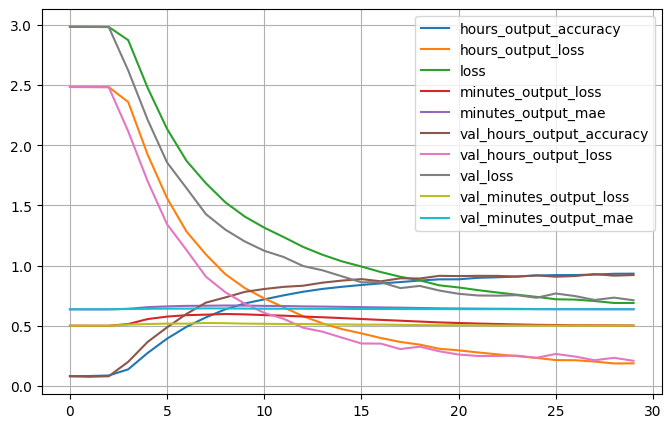

Validation hours_output_loss: 0.5015932321548462
Validation minutes_output_loss: 0.92166668176651
Test hours_output_loss: 0.502438485622406
Test minutes_output_loss: 0.9227777719497681


In [5]:
batch_size = 32
epochs = 30
# Build Model
input_ = Input(shape=(img_rows, img_cols, 1))

x = Conv2D(32, kernel_size=(3, 3),
                 activation='relu')(input_)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)

# Output
hours_output = Dense(12, activation='softmax', name='hours_output')(x)
minutes_output = Dense(2, activation='tanh', name='minutes_output')(x)


model = Model(inputs=[input_], outputs=[hours_output, minutes_output])
model.compile(loss={'hours_output':keras.losses.sparse_categorical_crossentropy, 'minutes_output': 'mean_squared_error'},
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics={'hours_output': 'accuracy', 'minutes_output': 'mae'})

# Fit Model
history = model.fit(train_images, {'hours_output': train_h_labels, 'minutes_output': train_min_labels},
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(val_images, {'hours_output': val_h_labels, 'minutes_output': val_min_labels}))

df = pd.DataFrame(history.history)
df.plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()
# Evaluate Model
score = model.evaluate(val_images, {'hours_output': val_h_labels, 'minutes_output': val_min_labels}, verbose=0)
print('Validation hours_output_loss:', score[2])
print('Validation minutes_output_loss:', score[3])
score_final = model.evaluate(test_images, {'hours_output': test_h_labels, 'minutes_output': test_min_labels}, verbose=0)
print('Test hours_output_loss:', score_final[2])
print('Test minutes_output_loss:', score_final[3])

In [6]:
def calculate_time_from_predictions(predictions):
    minute_sin, minute_cos = predictions[:, 0], predictions[:, 1]

    # Calculate angles for minutes
    minute_angle = np.arctan2(minute_sin, minute_cos)

    # Convert angles back to minute values
    minute = ((minute_angle % (2 * np.pi)) * (60 / (2 * np.pi))).astype(int)

    return minute

In [7]:
predictions = model.predict(test_images)
predicted_hours = np.argmax(predictions[0], axis=1)
predicted_minutes = calculate_time_from_predictions(predictions[1])

common_sense_errors = [common_sense_accuracy([predicted_hours[i], predicted_minutes[i]], test_labels[i]) 
                       for i in range(len(test_labels))]
print('Average common sense error:', np.mean(common_sense_errors))

/Users/chenyiru/miniconda3/envs/IDL/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Average common sense error: 22.27777777777778


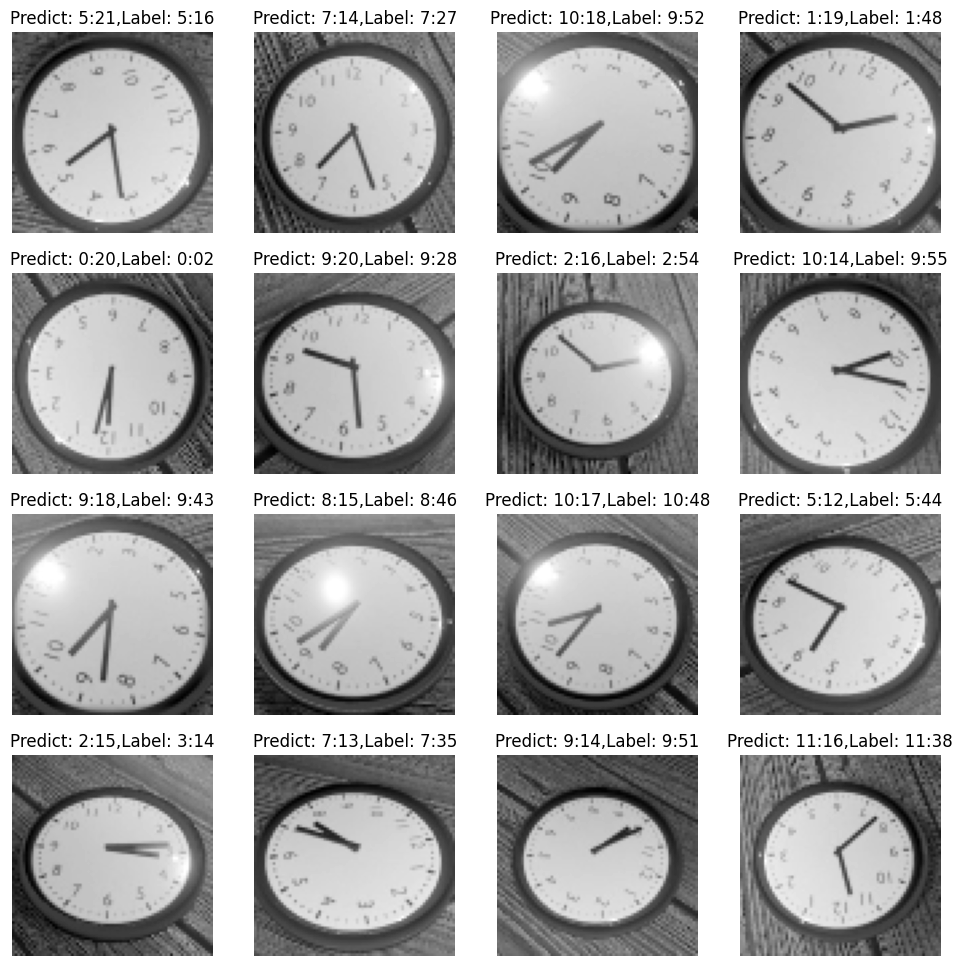

In [8]:
# Plot a sample of clock images
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f'Predict: {predicted_hours[i]}:{predicted_minutes[i]:02d},Label: {test_labels[i][0]}:{test_labels[i][1]:02d}')
    plt.axis('off')
plt.show()